In [17]:
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from IPython import display

In [18]:
%matplotlib inline
import numpy as np
import scipy.sparse as scsp
import matplotlib.pyplot as plt
import scipy.linalg as sclin
import scipy.sparse.linalg as scspl
from tqdm import tqdm

## Load data

In [19]:
n = 32
sigma = 1e-3
size = 5000

In [20]:
data = np.load("./data_n{}_sigma{}_size{}.npz".format(n, sigma, size))
X = data["X"]
y = data["y"]

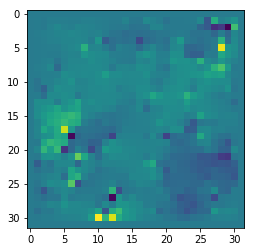

In [21]:
plt.imshow(X[3])

## Linear encoder via SVD

In [22]:
X_reshape = X.reshape(-1, n*n)
print(X_reshape.shape)
U, s, V = np.linalg.svd(X_reshape)

(5000, 1024)


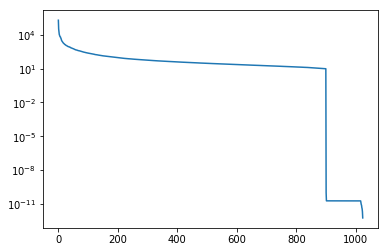

In [23]:
plt.semilogy(s)

In [24]:
hidden_dim = 50
print("Relative error = {}".format(np.linalg.norm(X_reshape - 
      U[:, :hidden_dim] @ np.diagflat(s[:hidden_dim]) @ V[:hidden_dim, :]) / np.linalg.norm(X_reshape)))

Relative error = 0.016195448471898813


## Nonlinear encoder

In [25]:
class nonlinear_autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, encoder_dims, activation=None, batch_norm=False):
        super(nonlinear_autoencoder, self).__init__()
        if len(encoder_dims) > 0:
            encoder_layers = [nn.Linear(input_dim, encoder_dims[0])]
            if batch_norm:
                encoder_layers.append(nn.BatchNorm1d(encoder_dims[0]))
            for i in range(len(encoder_dims)-1):
                if activation is not None:
                    encoder_layers.append(activation)
                encoder_layers.append(nn.Linear(encoder_dims[i], encoder_dims[i+1]))
                if batch_norm:
                    encoder_layers.append(nn.BatchNorm1d(encoder_dims[i+1]))
            else:
                if activation is not None:
                    encoder_layers.append(activation)
                encoder_layers.append(nn.Linear(encoder_dims[-1], hidden_dim))
                if batch_norm:
                    encoder_layers.append(nn.BatchNorm1d(hidden_dim))
        else:
            encoder_layers = [nn.Linear(input_dim, hidden_dim)]
        
        self.encoder = nn.Sequential(*encoder_layers)
        
        if len(encoder_dims) > 0:
            decoder_layers = [nn.Linear(hidden_dim, encoder_dims[-1])]
            if batch_norm:
                decoder_layers.append(nn.BatchNorm1d(encoder_dims[-1]))
            for i in range(len(encoder_dims)-1, 0, -1):
                if activation is not None:
                    decoder_layers.append(activation)
                decoder_layers.append(nn.Linear(encoder_dims[i], encoder_dims[i-1]))
                if batch_norm:
                    decoder_layers.append(nn.BatchNorm1d(encoder_dims[i-1]))
            else:
                if activation is not None:
                    decoder_layers.append(activation)
                decoder_layers.append(nn.Linear(encoder_dims[0], input_dim))
                if batch_norm:
                    decoder_layers.append(nn.BatchNorm1d(input_dim))
        else:
            decoder_layers = [nn.Linear(hidden_dim, input_dim)]
        
        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [90]:
learning_rate = 1e-4
num_epochs = 100
batch_size = 100

In [91]:
dataloader = DataLoader(X_reshape.astype(np.float32), batch_size=batch_size, shuffle=True)

In [112]:
encoder_dims = [512, 256, 128, 64]
activation = nn.ReLU(inplace=True)
# activation = nn.Dropout(p=0.1)

model = nonlinear_autoencoder(n*n, hidden_dim, encoder_dims, activation, batch_norm=False)
print(model)
criterion = nn.MSELoss()

nonlinear_autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU(inplace)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU(inplace)
    (8): Linear(in_features=64, out_features=50, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=50, out_features=64, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): ReLU(inplace)
    (6): Linear(in_features=256, out_features=512, bias=True)
    (7): ReLU(inplace)
    (8): Linear(in_features=512, out_features=1024, bias=True)
  )
)


In [113]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0)
# optimizer = torch.optim.SGD(model.parameters(), momentum=0.8, lr=learning_rate)

In [114]:
def train(model, optimizer, num_epochs, dataloader, yscale="log"):
    loss_hist = []
    for epoch in range(num_epochs):
        current_loss = []
        for img in dataloader:
            img = img.view(img.size(0), -1)
            img = Variable(img)
            # ===================forward=====================
            output = model(img)
            loss = criterion(output, img)
            current_loss.append(loss.data)
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # ===================log========================
        display.clear_output(wait=True)
        plt.figure(figsize=(8, 6))

        plt.title("Training loss")
        plt.xlabel("#iteration")
        plt.ylabel("loss")
        loss_hist.append(np.mean(np.array(current_loss)))
        plt.plot(loss_hist, 'b')
        if yscale == "log":
            plt.yscale("log")
        plt.show()

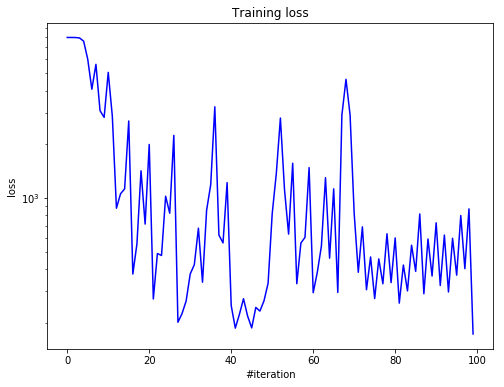

In [115]:
train(model, optimizer, num_epochs, dataloader, "log")

In [116]:
model.eval()
X_restored = model(Variable(torch.FloatTensor(X_reshape)))
print((np.linalg.norm(X_restored.data.numpy() - X_reshape)) / (np.linalg.norm(X_reshape)))

0.13540732459285304
